In [146]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [147]:
# Loading our two pipelines
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

config = {"punct_chars": [".", "?", "!", "。"]}
nlp.add_pipe('sentencizer', config=config)

In [148]:
# Using panda to load in our .csv file
df = pd.read_csv("urls.csv") # File we are checking
urls = df["Address"].tolist() # Column name we are checking
url_sent_score = []
url_sent_label = []
url_subj_score = []
url_subj_label = []
total_pos = []
total_neg = []

In [149]:
def get_named_entities(doc):
    ent_list = []
    for ent in doc.ents:
        ent_list.append((ent.text,ent.label_))
    return ent_list

def get_sentences(doc):
    return doc.sents

def get_sentence_list(doc):
    return [sent for sent in doc.sents]

def sentence_sentiment_from_doc(doc):
    sentences = get_sentences(doc)
    tuple_list = []
    for sentence in sentences:
        sent_doc = nlp(sentence.text)
        tuple_list.append((sentence,sent_doc._.blob.polarity))
    return tuple_list

#def sentence_sentiment_on_named_entities(doc):
    

In [150]:
#https://pypi.org/project/spacytextblob/
for count, x in enumerate(urls):
    try:
        url = x

        headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
        res = requests.get(url,headers=headers)
        html_page = res.text

        soup = BeautifulSoup(html_page, 'html.parser')
        for script in soup(["script", "style","meta","label","header","footer"]):
            script.decompose()
        page_text = (soup.get_text()).lower()
        page_text = page_text.strip().replace("  ","")
        page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])

        # Start the sentiment analysis now
        doc = nlp(page_text)
        sentiment = doc._.blob.polarity
        sentiment = round(sentiment,2)
        subjectivity = doc._.blob.subjectivity
        subjectivity = round(subjectivity,2)
        
        #exploration of single topic modeling and sentiment
        #print(doc._.blob.sentiment_assessments)
        #print([(w.text, w.pos_) for w in doc])
        
        if count / 1 == 1:
            print("enter test spot\n")
            ent_list = get_named_entities(doc)
            #print(ent_list)
            sentence_sentiment_list = sentence_sentiment_from_doc(doc)
            print(sentence_sentiment_list)
            break
            
        #print("\n")

        # Gives positive or negative label
        if sentiment >= -0.033 and sentiment <= 0.043:
            sent_label = "Neutral"
        elif sentiment > 0.043 and sentiment < 0.143:
            sent_label = "Neutral Positive"
        elif sentiment > 0.143:
            sent_label = "Positive"
        elif sentiment < -0.033 and sentiment > -0.062:
            sent_label = "Neutral Negative"
        elif sentiment < -0.062:
            sent_label = "Negative"

        url_sent_label.append(sent_label)
        url_sent_score.append(sentiment)
        url_subj_score.append(subjectivity)

        positive_words = []
        negative_words = []

        for x in doc._.blob.sentiment_assessments.assessments:
          if x[1] > 0:
            positive_words.append(x[0][0])
          elif x[1] < 0:
            negative_words.append(x[0][0])
          else:
            pass

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))
    except:
        url_sent_label.append("Error")
        url_sent_score.append(0.0)
        url_subj_score.append(0.0)

        positive_words = []
        negative_words = []

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))

# print("The average sentiment score was: " + str(sum(url_sent_score) / len(url_sent_score)))
# print("The average subjectivity score was: " + str(sum(url_subj_score) / len(url_subj_score)))

# df["Sentiment Score"] = url_sent_score
# df["Sentiment Label"] = url_sent_label
# df["Subjectivity Score"] = url_subj_score
# df["Positive Words"] = total_pos
# df["Negative Words"] = total_neg

# df

enter test spot

[(11 minutes of aerobics daily lowers disease risk, study says | cnn
 
 
11 minutes of daily exercise could have a positive impact on your health, large study shows
			by kristen rogers, cnn
		
updated
6:45 am est, wed march 1, 2023
link copied!
 
, 0.12378246753246752), (this may look silly, but a new study reveals its benefits to your daily routine
02:34
 - source:
cnn
your health
16 videos
this may look silly, but a new study reveals its benefits to your daily routine
02:34
now playing
 - source:
, -0.12121212121212122), (cnn
if you have allergies, you may want to avoid this type of medication
02:18
now playing
 - source:
cnn
doctor explains new over-the-counter medicine that's a 'complete antidote to opioids'
01:59
now playing
 - source:
cnn
maternity wards across the us are closing because of this issue
02:31
now playing
 - source:
cnn
nearly 40% of dementia cases can be prevented with one small health change
02:13
now playing
 - source:
cnn
this type of exercise 

In [151]:
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText
from nltk import pos_tag, word_tokenize
import numpy as np
import os
from random import shuffle
import re
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt 
import numpy as np
import pyLDAvis
import pyLDAvis.gensim


In [152]:
x = get_sentence_list(doc)
input_text = [str(sentence) for sentence in x]


In [153]:
# store as list of lists of words
sentences_ted = []
for sent_str in input_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

stoplist = []
with open('stopwords') as openfileobject:
    for line in openfileobject:
        stoplist.append(line[:-1])
stoplist = set(stoplist)

for i in range(len(sentences_ted)):
    for word in reversed(sentences_ted[i]):
        if word in stoplist:
            sentences_ted[i].remove(word)

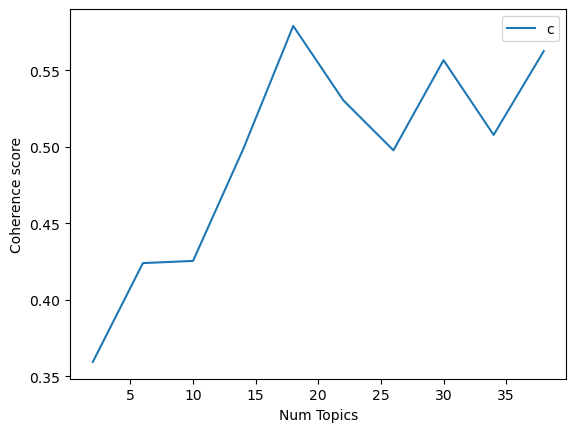

In [154]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=sentences_ted, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=sentences_ted, start=2, limit=40, step=4)
# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [155]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 18 topics gives the highest coherence score 
of 0.5788704352880092


In [156]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary)
p

c:\Users\biehl\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.281720  0.103838       1        1  25.845575
4      0.103849  0.044026       2        1  11.448018
10     0.076376  0.016224       3        1   6.396895
3      0.073004  0.115808       4        1   6.103192
15    -0.017807 -0.170671       5        1   5.920531
17     0.049035 -0.065302       6        1   5.753187
11     0.097553  0.104451       7        1   5.549919
13     0.058933 -0.003030       8        1   4.281183
9      0.025381 -0.076649       9        1   4.277199
8      0.066189  0.028599      10        1   4.130740
7      0.071308  0.007849      11        1   3.937172
1     -0.051658  0.046123      12        1   3.891040
12    -0.069564 -0.054146      13        1   3.477632
6     -0.024522 -0.015757      14        1   3.433043
16    -0.029663 -0.056693      15        1   2.691596
14    -0.063916 -0.007202      16        1   1.731027
5     -0.039283 -0.009445      17        1   0.846749
2     -0.043494 -0.008022      18        1   0.285302, topic_info=         Term      Freq      Total Category  logprob  loglift
6         cnn  19.00000  19.000000  Default  30.0000  30.0000
40     source  15.00000  15.000000  Default  29.0000  29.0000
36    playing  14.00000  14.000000  Default  28.0000  28.0000
207  research   6.00000   6.000000  Default  27.0000  27.0000
163  activity  12.00000  12.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
1          11   0.00551   3.896737  Topic18  -6.1619  -0.7020
2        2023   0.00551   1.162150  Topic18  -6.1619   0.5078
3          45   0.00551   2.054438  Topic18  -6.1619  -0.0619
4           6   0.00551   1.162148  Topic18  -6.1619   0.5078
5    aerobics   0.00551   1.162156  Topic18  -6.1619   0.5078

[770 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
42        1  0.993453        01
29        1  0.948085        02
44        1  0.848919        05
0        12  0.860473         1
214       1  0.352036        10
...     ...       ...       ...
341       5  0.818417     world
194       2  0.513260     would
194       9  0.513260     would
345       9  0.860633     wrote
253       2  0.736553  zhongfei

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 11, 4, 16, 18, 12, 14, 10, 9, 8, 2, 13, 7, 17, 15, 6, 3])

In [157]:
for topic_id, topic_words in model_topics:
    print(f"Topic {topic_id + 1}:")
    for word, weight in topic_words:
        print(f"\t{word}: {weight}")

Topic 6:
	conversation: 0.03261319547891617
	intensity: 0.03261319547891617
	marked: 0.03261319547891617
	carry: 0.03261319547891617
	vigorous: 0.03261319175362587
	inability: 0.03261318802833557
	benefits: 0.0018070953665301204
	may: 0.001800738275051117
	study: 0.001791992923244834
	34: 0.0017912171315401793
Topic 16:
	study: 0.024684138596057892
	exercise: 0.02466299757361412
	kids: 0.024658866226673126
	engage: 0.024658864364027977
	something: 0.024658849462866783
	better: 0.024407606571912766
	none: 0.024407606571912766
	health: 0.012676050886511803
	cycle: 0.01266254112124443
	active: 0.01266254112124443
Topic 7:
	cancer: 0.03647474944591522
	watts: 0.036125361919403076
	said: 0.01873817853629589
	levels: 0.01873522810637951
	function: 0.018734091892838478
	fat: 0.018731432035565376
	fellow: 0.018731139600276947
	body: 0.01873011328279972
	lung: 0.01872979663312435
	benefits: 0.01872844249010086
Topic 12:
	lower: 0.06532739847898483
	risk: 0.06531229615211487
	dying: 0.0394064858